<a href="https://colab.research.google.com/github/mr-unique-appraiser/SpotifyMusicRecommendationSystem/blob/main/SpotifyMusicRecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
pip install spotipy

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import spotipy
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

In [66]:
data = pd.read_csv('/content/data.csv')
genre_data = pd.read_csv('/content/data_by_genres.csv')
year_data = pd.read_csv('/content/data_by_year.csv')

In [67]:
print(data.info())
print(genre_data.info())
print(year_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24136 entries, 0 to 24135
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valence           24136 non-null  float64
 1   year              24136 non-null  int64  
 2   acousticness      24136 non-null  float64
 3   artists           24136 non-null  object 
 4   danceability      24136 non-null  float64
 5   duration_ms       24136 non-null  int64  
 6   energy            24136 non-null  float64
 7   explicit          24136 non-null  int64  
 8   id                24136 non-null  object 
 9   instrumentalness  24136 non-null  float64
 10  key               24135 non-null  float64
 11  liveness          24135 non-null  float64
 12  loudness          24135 non-null  float64
 13  mode              24135 non-null  float64
 14  name              24135 non-null  object 
 15  popularity        24135 non-null  float64
 16  release_date      24135 non-null  object

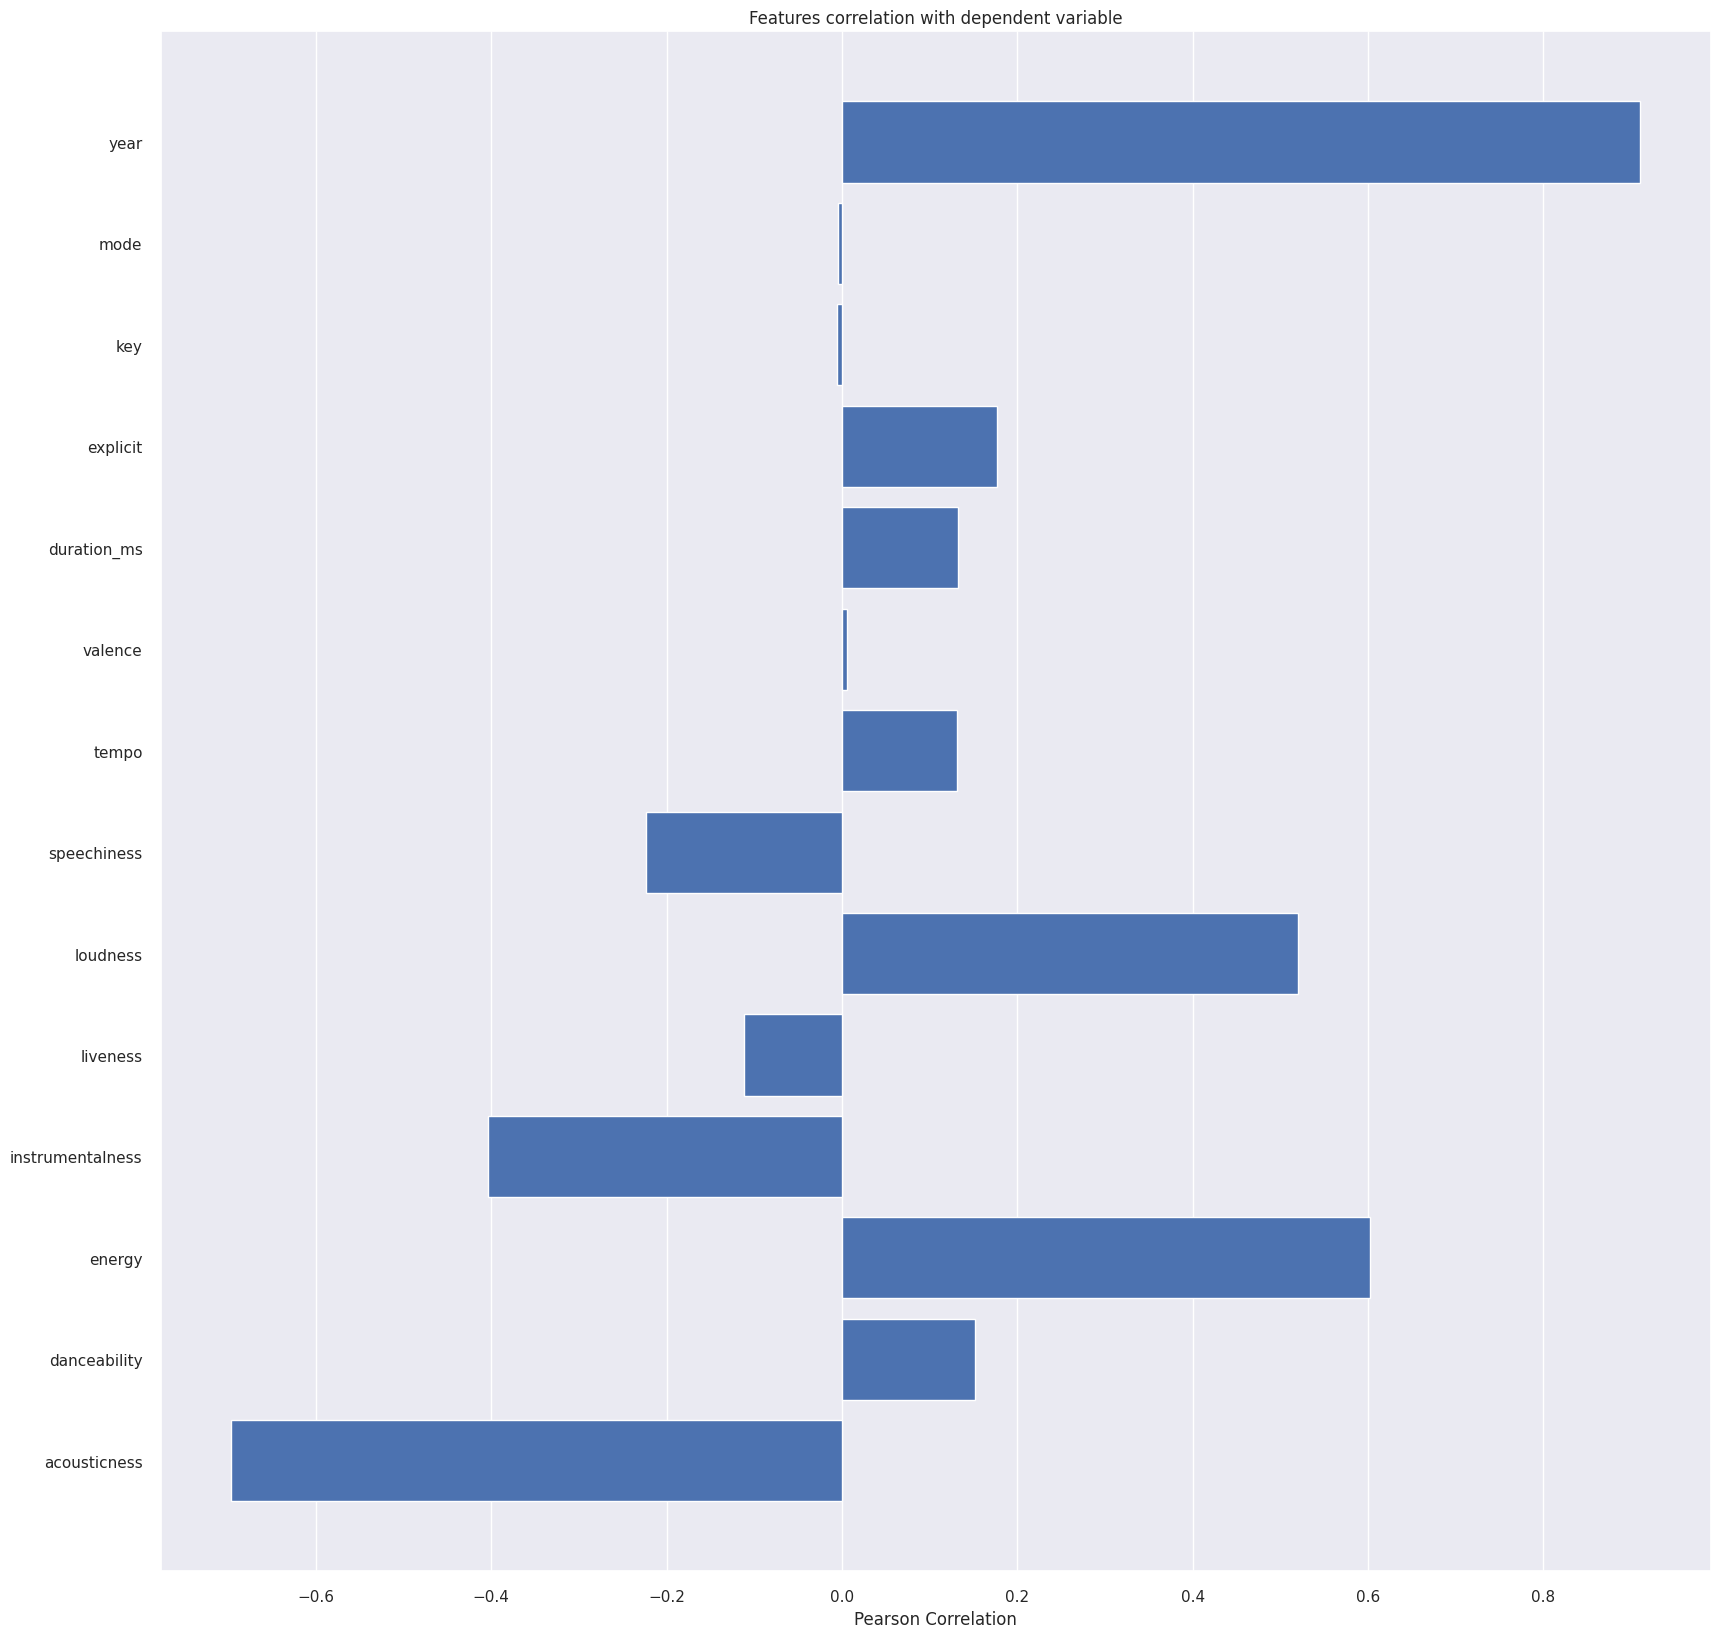

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [68]:
from yellowbrick.target import FeatureCorrelation

feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms','explicit','key','mode','year']
X, y = data[feature_names], data['popularity']
X.fillna(X.mean(),inplace=True)
y.fillna(y.mean(),inplace=True)
# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(20,20)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

<Axes: xlabel='decade', ylabel='count'>

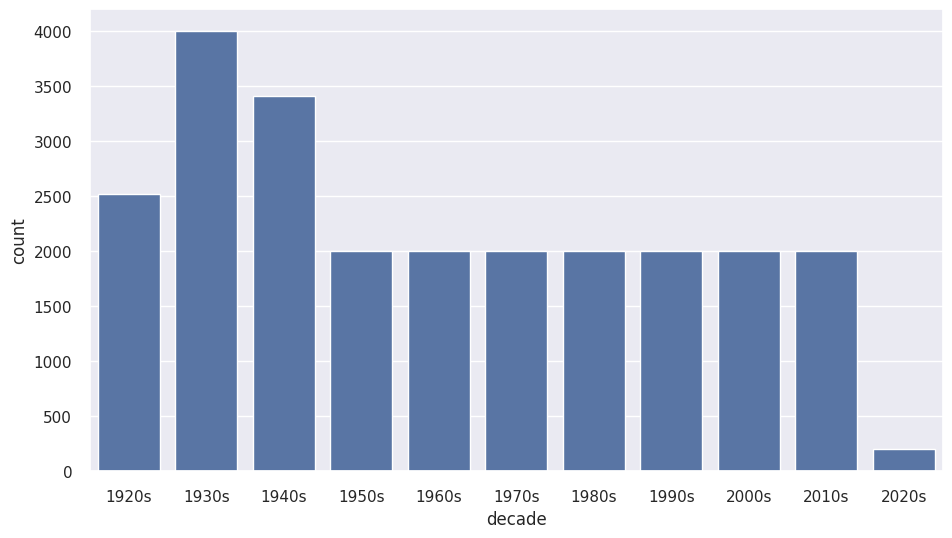

In [69]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

data['decade'] = data['year'].apply(get_decade)
sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(x=data['decade'])

In [70]:
import plotly.express as px

In [71]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness','valence']
fig = px.line(year_data, x='year', y=sound_features)
fig.show()


In [72]:
top10_genres = genre_data.nlargest(10, 'popularity')
fig = px.bar(top10_genres, x='genres', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.show()

In [73]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10, n_init="auto"))])
X = genre_data.select_dtypes(np.number)
cluster_pipeline.fit(X)
genre_data['cluster'] = cluster_pipeline.predict(X)

In [74]:
from sklearn.manifold import TSNE

In [75]:
tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=1))])
genre_embedding = tsne_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = genre_data['genres']
projection['cluster'] = genre_data['cluster']
fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2973 samples in 0.006s...
[t-SNE] Computed neighbors for 2973 samples in 0.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2973
[t-SNE] Computed conditional probabilities for sample 2000 / 2973
[t-SNE] Computed conditional probabilities for sample 2973 / 2973
[t-SNE] Mean sigma: 0.777516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.106247
[t-SNE] KL divergence after 1000 iterations: 1.392902


In [76]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()),('kmeans', KMeans(n_clusters=20,verbose=False, n_init="auto"))], verbose=False)
X = data.select_dtypes(np.number)
X.fillna(X.mean(), inplace=True)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

In [77]:
from sklearn.decomposition import PCA
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']
fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

In [78]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="7e75aa1ffc82425a927bd337cac21290",client_secret="eba567d10e5b4c5d8c45ede522861092"))
def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None
    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]
    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]
    for key, value in audio_features.items():
        song_data[key] = value
    return pd.DataFrame(song_data)


In [79]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib
number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']
def get_song_data(song, spotify_data):
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name'])
                    & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data
    except IndexError:
        return find_song(song['name'], song['year'])

def get_mean_vector(song_list, spotify_data):

    song_vectors = []

    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        if len(song_vectors) > 0 and len(song_vector) != len(song_vectors[0]):
            print(f"Warning: Skipping song {song['name']} due to shape mismatch.")
            continue
        song_vectors.append(song_vector)
    if not song_vectors:
        return None
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
    return flattened_dict


def recommend_songs( song_list, spotify_data, n_songs=10):
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data,'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [80]:
recommend_songs(song_list=[{'name': 'Come As You Are', 'year':1991},{'name': 'Smells Like Teen Spirit', 'year': 1991},{'name': 'Lithium', 'year': 1992},{'name': 'All Apologies', 'year': 1993},{'name': 'Stay Away', 'year': 1993}],  spotify_data=data)

[{'name': 'Otherside', 'year': 1999, 'artists': "['Red Hot Chili Peppers']"},
 {'name': 'Gold on the Ceiling',
  'year': 2011,
  'artists': "['The Black Keys']"},
 {'name': 'Fuel', 'year': 1997, 'artists': "['Metallica']"},
 {'name': 'Sleep Now In the Fire',
  'year': 1999,
  'artists': "['Rage Against The Machine']"},
 {'name': 'Hanging By A Moment', 'year': 2000, 'artists': "['Lifehouse']"},
 {'name': 'Little Talks', 'year': 2012, 'artists': "['Of Monsters and Men']"},
 {'name': 'Runaway (U & I)', 'year': 2015, 'artists': "['Galantis']"},
 {'name': 'Wake Me Up', 'year': 2013, 'artists': "['Avicii']"},
 {'name': 'Chandelier', 'year': 2015, 'artists': "['Sia']"}]